1. 필요한 모듈 설치하기

In [1]:
!sudo apt-get install python3-dev default-libmysqlclient-dev
# DB
!pip install pymysql

# 한글 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
default-libmysqlclient-dev is already the newest version (1.0.8).
default-libmysqlclient-dev set to manually installed.
python3-dev is already the newest version (3.10.6-1~22.04).
python3-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program

2. 한글 설정을 위한 런타임 재시작.

In [ ]:
# 런타임 재시작
import os
os.kill(os.getpid(), 9)

3. 필요 라이브러리 및 폰트 적용

In [1]:
import pymysql
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt # 맷플롯립 import 하기
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

4. 데이터 베이스 연결

In [2]:
username = 'root'
password = '***'
host = '***'  # or your_host:your_port  # or your_host:your_port
port=3306
database = 'furry_friend_product'

conn = pymysql.connect(host=host, port=port, user=username, password=password, db=database)

5. 데이터 베이스 쿼리 실행

In [9]:
query = "SELECT pname, pprice, pcategory FROM product"

6. 데이터 베이스 데이터 수집 후 데이터 프레임으로 변환.

In [10]:
df = pd.read_sql_query(query, conn)

<ipython-input-10-f9b1d64a098d>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


7. 데이터 전처리 코드

*   상품 무료 나눔 혹은 장난으로 올린 상품 필터링.
*   카테고리 데이터 평균 데이터 그룹화.
*   카테고리 고유 값 분리.


In [11]:
# 1.
df = df[(df['pprice'] > 100) & (df['pprice'] < 10000000)]

# 2.
grouped_df = df.groupby('pcategory')['pprice'].mean().astype(int)

# 3.
categories = df['pcategory'].unique()

8. 데이터 시각화


*   꺽은선 그래프.
*   막대 그래프.
*   원-핫 인코딩 적용
*   훈련/테스트 세트 분리
*   선형 회귀 모델 훈련
*   가격 예측 함수 생성

In [13]:
# 원-핫 인코딩 적용
one_hot = pd.get_dummies(df['pcategory'])
df1 = df.drop('pcategory',axis = 1)
df1 = df1.join(one_hot)


# 훈련/테스트 세트 분리 (여기서는 80%/20% 비율로 분리)
train_df, test_df = train_test_split(df1, test_size=0.2)

# 선형회귀모델 훈련
model = LinearRegression()
model.fit(train_df.drop(['pprice', 'pname'], axis=1), train_df['pprice'])

def predict_price(pname, pcategory):
    # 입력받은 'pcategory'를 원-핫 인코딩
    encoded_category = one_hot.columns == pcategory

    # 모델에 입력할 데이터 생성
    input_data = pd.Series(encoded_category, index=one_hot.columns).astype(int)

    # 가격 예측
    predicted_price = model.predict([input_data])
    return int(predicted_price[0])

9. 데이터 시각화


*   각 카테고리 별 가격 꺾은선 그래프로 시각화
*   각 카테고리 별 평균 가격 막대 그래프로 시각화
*   가격 예측 함수를 실행하여 입력 데이터의 가격 예측 시각화



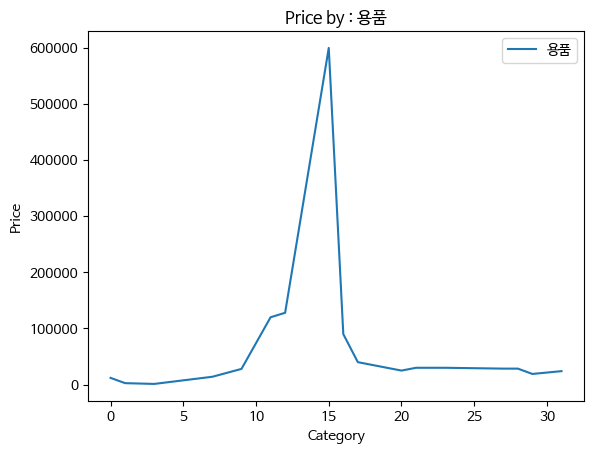

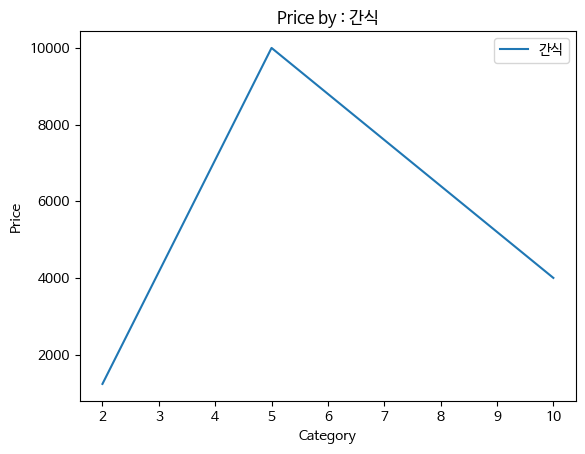

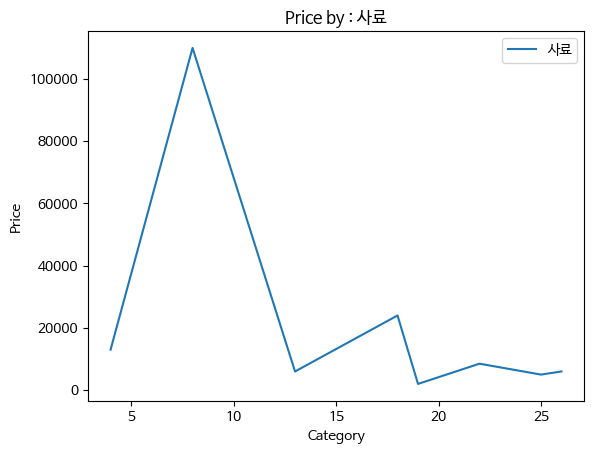

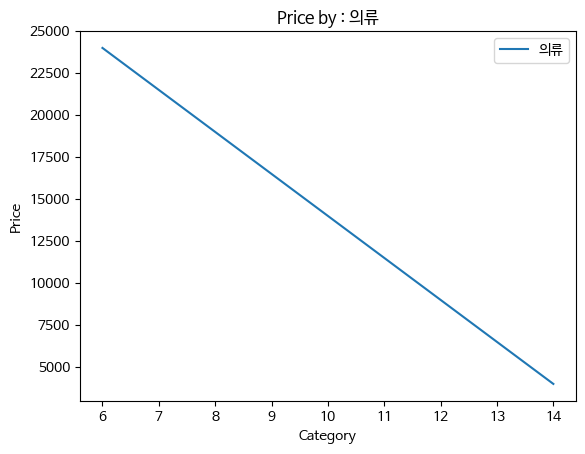

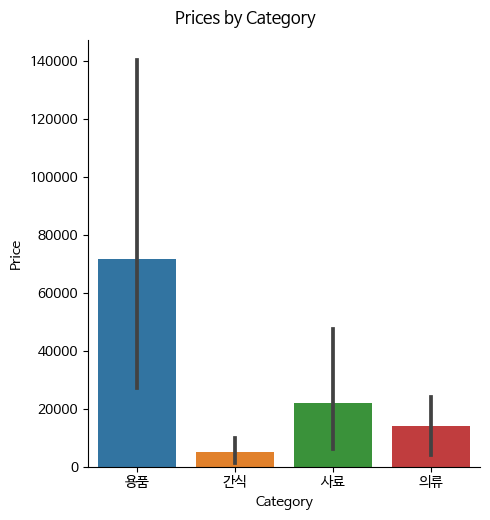

테스트용 상품의 예상 가격은 86641입니다.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [14]:
# 꺾은선 그래프 그리기
for category in categories:
    filtered_df = df[df['pcategory'] == category]
    sns.lineplot(x=filtered_df.index, y=filtered_df['pprice'], label=category)

    # 그래프의 제목과 축 라벨 설정
    plt.title('Price by : ' + category)
    plt.xlabel('Category')
    plt.ylabel('Price')

    plt.show()

# 'pcategory'별로 각각의 막대 그래프를 그림
g = sns.catplot(x='pcategory', y='pprice', data=df, kind='bar')
# 그래프의 제목과 축 라벨을 설정
g.fig.suptitle('Prices by Category', y=1.03)
g.set_xlabels('Category')
g.set_ylabels('Price')
plt.show()

# 가격 예측 함수
pname = "테스트용 상품"
pcategory = "용품"
print(f"{pname}의 예상 가격은 {predict_price(pname, pcategory)}입니다.")

